In [ ]:
import os

import numpy as np
import pandas as pd
import h5py

import pickle

import xtrack as xt
import xpart as xp
import xwakes as xw
import xobjects as xo

from scipy.constants import c as clight

import matplotlib as mpl
import matplotlib.pyplot as plt


# !start-simulation-settings!

##### Machine parameters
circumference = 27000.0
machine_radius = circumference / (2*np.pi)

##### Parameters for the resistive wall wake
plane = 'x'
wake_type = 'dipolar'

# scale_factor = 1.0 # A scaling factor for the impedance
# resistivity = 1.7e-8 * scale_factor**2 # Ohm m / Copper at 293 K
# pipe_radius = 10.0e-3

wake_table = 'data/wake_lhc_injection.dat'
# wake_table = './wakefield_data/HLLHC_wake_flattop_nocrab.dat'
# The length of the resistive wall will be the full circumference

##### Initial offset to the particles x coordinate
initial_offset = 10.0e-6

##### Acceleration parameters
energy_gain_per_turn = 0
main_rf_phase = 180

##### RF parameters
h_RF = np.array([35640,])
V_RF = np.array([8.0e6])
dphi_RF = np.array([main_rf_phase,])
f_rev = 299792458 / circumference
omega_rev = 2*np.pi*f_rev
f_RF = np.array([f_rev*h for h in h_RF])

##### Optics parameters
alphap = 3.48e-4

Qx_frac = 0.275
Qy_frac = 0.295
Qx_int = 64
Qy_int = 59

Qx = Qx_int + Qx_frac
Qy = Qy_int + Qy_frac

##### Chromaticity
chromaticity = 0
print('Qp:', chromaticity)

##### Bunch parameters
p0c = 450.0e9
bucket_length = circumference / h_RF[0]
nemitt_x = 2.0e-6
nemitt_y = 2.0e-6
taub = 1.0e-9    # Full bunch length (4*sigma_z)
sigma_z = taub * clight / 4

# We use a limited amount of MP to have a general view of the wake effects
n_macroparticles = int(50_000)
num_slices = int(150)

# Bunch intensity scan
delta_bint = 0.1e12
bunch_intensity_scan = np.arange(1.6e12, 2.1e12, delta_bint)
print('Bunch intensity scan:', bunch_intensity_scan)

# Number of turns simulated
number_of_turns = 10_000

# Save or not some plots (wakefield, emittance growth)
flag_plot = True

# Restart tracking simulations even if they were already done
flag_restart_sim = True

# !end-simulation-settings!

Qp: 0
Bunch intensity scan: [1.6e+12 1.7e+12 1.8e+12 1.9e+12 2.0e+12]


In [30]:
# Create the reference particle for xtrack
reference_particle = xt.Particles(mass0=xp.PROTON_MASS_EV, p0c=p0c)

beta0 = reference_particle.beta0[0]
gamma0 = reference_particle.gamma0[0]


In [31]:
wake_hllhc = xw.read_headtail_file(wake_table, ['time', 'dipole_x', 'dipole_y', 'quadrupolar_x', 'quadrupolar_y'])
wake_for_tracking_hllhc = xw.WakeFromTable(table=wake_hllhc, columns=['dipole_x'])


In [32]:
#### Configure the wake for tracking
wake_for_tracking = wake_for_tracking_hllhc
wake_for_tracking.configure_for_tracking(
    zeta_range=(-0.375, 0.375),
    num_slices=num_slices,
    num_turns=1,
)

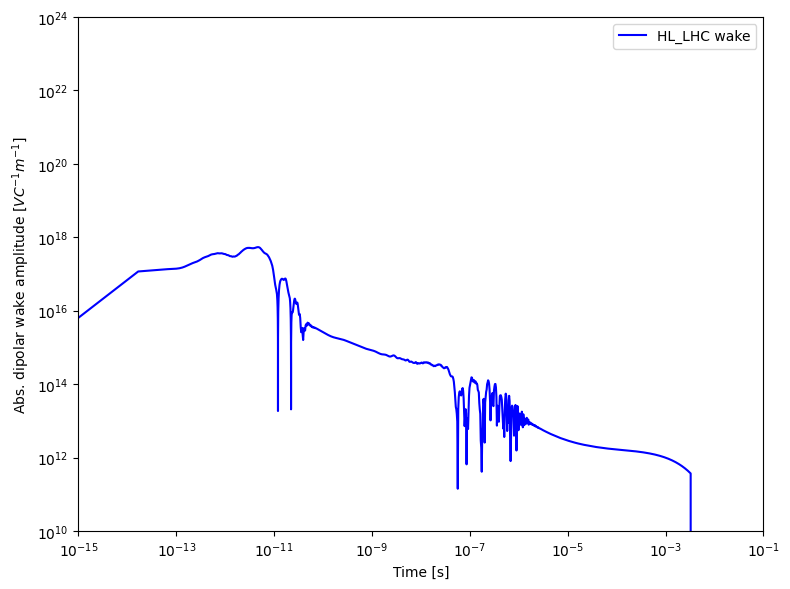

In [33]:
# Plot the wake model
if flag_plot:
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(wake_hllhc['time'], np.abs(wake_hllhc['dipole_x']), marker=None,c='b', label='HL_LHC wake')

    ax.legend()

    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Abs. dipolar wake amplitude [$V C^{-1} m^{-1}$]')

    ax.set_xlim(1e-15, 1e-1)
    ax.set_ylim(1e10, 1e24)
    ax.set_xscale('log')
    ax.set_yscale('log')

    plt.tight_layout()
    plt.savefig('wake_for_tracking.png')

In [34]:
# The line for Q' = 0 will be used for the twiss
segment_map = xt.LineSegmentMap(
    length=circumference,
    betx=machine_radius/Qx, bety=machine_radius/Qy,
    dnqx=[Qx_frac, 0], dnqy=[Qy_frac, 0],
    longitudinal_mode='linear_fixed_rf',
    voltage_rf=V_RF, frequency_rf=f_RF,
    lag_rf=dphi_RF, momentum_compaction_factor=alphap
    )


# Construct the full OTM with line segments and WF elements
one_turn_map_elements = [segment_map,]

total_number_of_elements = np.shape(one_turn_map_elements)
print(f'Length of OTM = {total_number_of_elements}')

# Compile the line
reference_line = xt.Line(one_turn_map_elements)
reference_line.particle_ref = reference_particle

# Compute the twiss parameters
tw = reference_line.twiss()

Qs = tw.qs
eta = tw.slip_factor
print(f'Qs = {Qs}, eta = {eta}')

# Save all the twiss keys
with open('twiss_qp0.pkl', 'wb') as f:
    pickle.dump(tw, f)

Length of OTM = (1,)
Qs = 0.005886788114278452, eta = 0.00034357423629046454


In [35]:
for bunch_intensity in bunch_intensity_scan:
    print(f'Simulation for b_int = {bunch_intensity:.2e}')

    if (not os.path.isfile(f'./bunchmonitor_data_hllhc_n{num_slices}_n{num_slices}_n{num_slices}_n{num_slices}_n{num_slices}_n{num_slices}_n{num_slices}_n{num_slices}_n{num_slices}_n{num_slices}/bunchmonitor_bint_{bunch_intensity:.2e}_bunches.h5')) or flag_restart_sim:
        print(f'File bunchmonitor_data_hllhc_n{num_slices}/bunchmonitor_bint_{bunch_intensity:.2e}_bunches.h5 not found or flag_restart_sim active, starting simulation')
        os.makedirs(f'./bunchmonitor_data_hllhc_n{num_slices}', exist_ok=True)

        segment_map = xt.LineSegmentMap(
            length=circumference,
            betx=machine_radius/Qx, bety=machine_radius/Qy,
            dnqx=[Qx_frac, chromaticity], dnqy=[Qy_frac, chromaticity],
            longitudinal_mode='linear_fixed_rf',
            voltage_rf=V_RF, frequency_rf=f_RF,
            lag_rf=dphi_RF, momentum_compaction_factor=alphap
            )


        # Create monitors at each RF station
        # initialize a monitor for the average transverse positions
        flush_data_every = int(500)
        particle_monitor_mask = np.full(n_macroparticles, False, dtype=bool)
        particle_monitor_mask[0:5] = True
            
        monitor = xw.CollectiveMonitor(
            base_file_name=f'./bunchmonitor_data_hllhc_n{num_slices}/bunchmonitor_with_bellows_bint_{bunch_intensity:.2e}',
            monitor_bunches=True,
            monitor_slices=True,
            monitor_particles=False,
            particle_monitor_mask=particle_monitor_mask,
            flush_data_every=flush_data_every,
            stats_to_store=['mean_x', 'mean_y', 'mean_px', 'sigma_x', 'epsn_x', 'num_particles'],
            stats_to_store_particles=['x', 'px'],
            backend='hdf5',
            zeta_range=(-0.3*bucket_length, 0.3*bucket_length),
            num_slices=num_slices//2,
            bunch_spacing_zeta=circumference,
        )

        # Construct the full OTM with line segments and WF elements
        one_turn_map_elements = [monitor, segment_map, wake_for_tracking]

        total_number_of_elements = np.shape(one_turn_map_elements)
        print(f'Length of OTM = {total_number_of_elements}')


        # Compile the line
        line = xt.Line(one_turn_map_elements)
        line.particle_ref = reference_particle
        line.build_tracker()

        # initialize a matched gaussian bunch
        particles = xp.generate_matched_gaussian_bunch(
            num_particles=n_macroparticles,
            total_intensity_particles=bunch_intensity,
            nemitt_x=nemitt_x, nemitt_y=nemitt_y,
            sigma_z=sigma_z,
            line=line,
        )

        # apply a kick to the particles
        particles.x += initial_offset

        turn_range = np.arange(0, number_of_turns, 1)

        # Track
        line.track(particles, num_turns=number_of_turns, with_progress=True)
    
    else:
        print(f'File bunchmonitor_with_bellows_bint_{bunch_intensity:.2e}.h5 found, skipping simulation')

Ignoring collective elements in particles generation.
Ignoring collective elements in particles generation.


Simulation for b_int = 1.60e+12
File bunchmonitor_data_hllhc_n150/bunchmonitor_bint_1.60e+12_bunches.h5 not found or flag_restart_sim active, starting simulation
Length of OTM = (3,)


Tracking:   0%|          | 0/10000 [00:00<?, ?it/s]

Ignoring collective elements in particles generation.
Ignoring collective elements in particles generation.


Simulation for b_int = 1.70e+12
File bunchmonitor_data_hllhc_n150/bunchmonitor_bint_1.70e+12_bunches.h5 not found or flag_restart_sim active, starting simulation
Length of OTM = (3,)


Tracking:   0%|          | 0/10000 [00:00<?, ?it/s]

Ignoring collective elements in particles generation.
Ignoring collective elements in particles generation.


Simulation for b_int = 1.80e+12
File bunchmonitor_data_hllhc_n150/bunchmonitor_bint_1.80e+12_bunches.h5 not found or flag_restart_sim active, starting simulation
Length of OTM = (3,)


Tracking:   0%|          | 0/10000 [00:00<?, ?it/s]

Ignoring collective elements in particles generation.
Ignoring collective elements in particles generation.


Simulation for b_int = 1.90e+12
File bunchmonitor_data_hllhc_n150/bunchmonitor_bint_1.90e+12_bunches.h5 not found or flag_restart_sim active, starting simulation
Length of OTM = (3,)


Tracking:   0%|          | 0/10000 [00:00<?, ?it/s]

Ignoring collective elements in particles generation.
Ignoring collective elements in particles generation.


Simulation for b_int = 2.00e+12
File bunchmonitor_data_hllhc_n150/bunchmonitor_bint_2.00e+12_bunches.h5 not found or flag_restart_sim active, starting simulation
Length of OTM = (3,)


Tracking:   0%|          | 0/10000 [00:00<?, ?it/s]

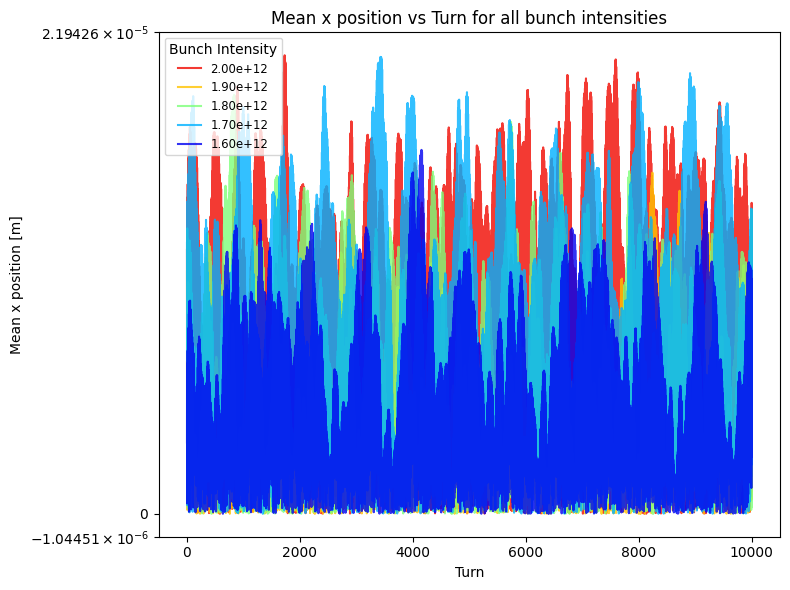

In [36]:
fig, ax = plt.subplots(figsize=(8, 6))

cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0.9, 0.1, len(bunch_intensity_scan)))

for i, bint in enumerate(reversed(bunch_intensity_scan)):
    file_path = f'./bunchmonitor_data_hllhc_n{num_slices}/bunchmonitor_with_bellows_bint_{bint:.2e}_bunches.h5'
    try:
        with h5py.File(file_path, 'r') as h5file:
            mean_x = h5file['0']['mean_x'][:]
            ax.plot(np.abs(mean_x), color=colors[i], label=f'{bint:.2e}', alpha=0.8)
    except FileNotFoundError:
        print(f'File not found: {file_path}')

ax.set_yscale('symlog')
ax.set_xlabel('Turn')
ax.set_ylabel('Mean x position [m]')
ax.set_title('Mean x position vs Turn for all bunch intensities')
ax.legend(title='Bunch Intensity', fontsize='small', loc='best')
fig.tight_layout()
plt.savefig('turn_by_turn_data_with_bellows_all_bints.png')
plt.show()

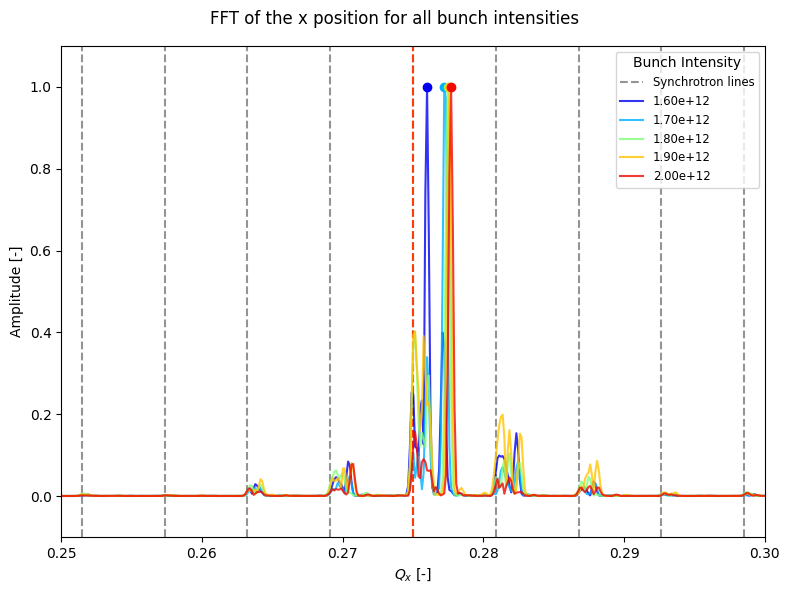

In [37]:
fig, ax = plt.subplots(figsize=(8, 6))

# Show the synchrotron sideband expected position around the tune at zero intensity
ax.vlines([Qx_frac + ii*Qs for ii in range(-5, 6)], ymin=-0.1, ymax=1.1, color='xkcd:grey',
          linestyle='--', label='Synchrotron lines')
ax.vlines([Qx_frac], ymin=-0.1, ymax=1.1, linestyle='--', color='xkcd:red orange')

n_turns_fft = 8192
window = np.kaiser(n_turns_fft, beta=14)

cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0.1, 0.9, len(bunch_intensity_scan)))

for i, bint in enumerate(bunch_intensity_scan):
    file_path = f'./bunchmonitor_data_hllhc_n{num_slices}/bunchmonitor_with_bellows_bint_{bint:.2e}_bunches.h5'
    try:
        with h5py.File(file_path, 'r') as h5file:
            mean_x = h5file['0']['mean_x'][:]
            if len(mean_x) >= n_turns_fft:
                x_values = np.fft.rfftfreq(n_turns_fft, d=1.0)
                y_values = np.abs(np.fft.rfft(mean_x[-n_turns_fft:] * window))
                y_norm = y_values / np.max(y_values)
                ax.plot(x_values, y_norm, color=colors[i], label=f'{bint:.2e}', alpha=0.8)
                ax.scatter(x_values[np.argmax(y_values)], 1, color=colors[i], zorder=10)
            else:
                print(f'Not enough turns for FFT in file: {file_path}')
    except FileNotFoundError:
        print(f'File not found: {file_path}')

ax.set_xlabel('$Q_x$ [-]')
ax.set_ylabel('Amplitude [-]')
ax.set_xlim(0.25, 0.3)
ax.set_ylim(-0.1, 1.1)
ax.legend(title='Bunch Intensity', fontsize='small', loc='best')
fig.suptitle('FFT of the x position for all bunch intensities')
fig.tight_layout()
plt.savefig('fft_x_position_all_bints.png')
plt.show()


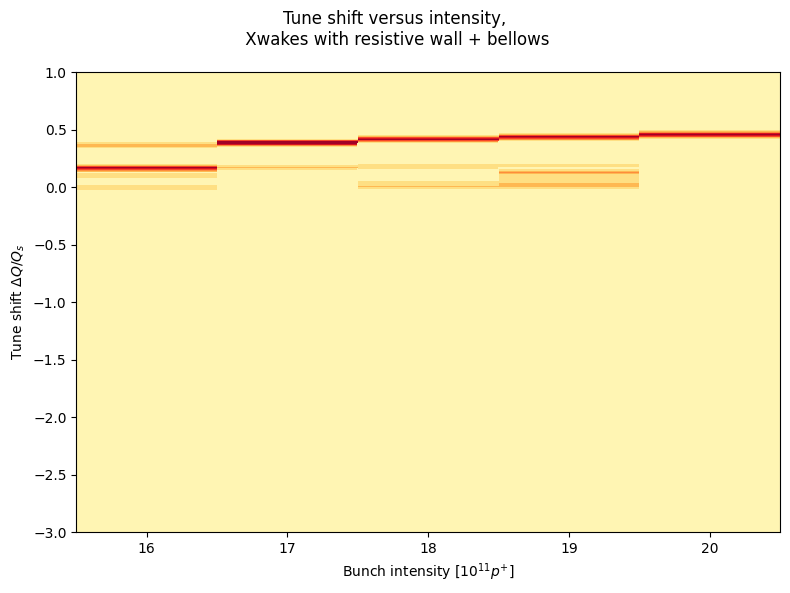

In [38]:
# Now plot the FFT for all the bunch intensities that were simulated
fig, ax = plt.subplots(figsize=(8, 6))

for bint in bunch_intensity_scan:
    with h5py.File(f'./bunchmonitor_data_hllhc_n{num_slices}/bunchmonitor_with_bellows_bint_{bint:.2e}_bunches.h5', 'r') as h5file:
        mean_x = h5file['0']['mean_x'][:]

    n_turns_fft = 8192
    window = np.kaiser(n_turns_fft, beta=6)

    x_values = np.linspace(bint-delta_bint/2, bint+delta_bint/2, 2)/1e11
    
    y_values = (np.fft.rfftfreq(len(mean_x[-n_turns_fft:]), d=1.0) - Qx_frac) / Qs
    
    z_values = np.abs(np.fft.rfft(mean_x[-n_turns_fft:]*window))
    z_values = (z_values / np.max(z_values))

    X, Y = np.meshgrid(x_values, y_values)
    Z = np.tile(z_values, (2, 1)).T

    ax.contourf(X, Y, Z, cmap='YlOrRd')

ax.set_ylim(-3, 1)

ax.set_xlabel('Bunch intensity [$10^{11} p^{+}$]')
ax.set_ylabel('Tune shift $\Delta Q/Q_s$')

fig.suptitle('Tune shift versus intensity,\n Xwakes with resistive wall + bellows')

fig.tight_layout()

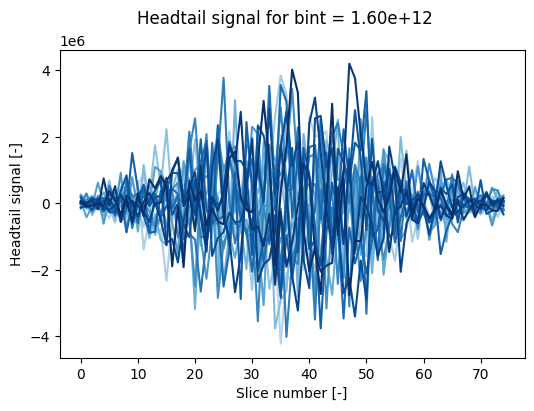

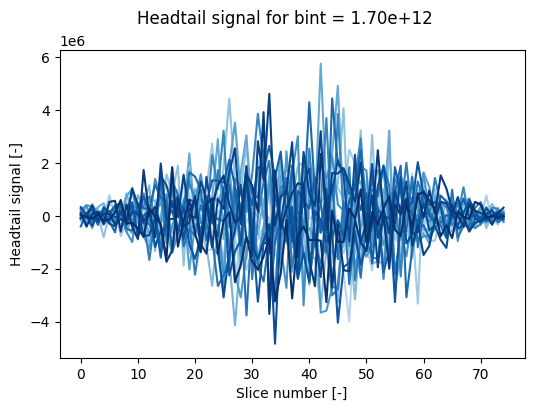

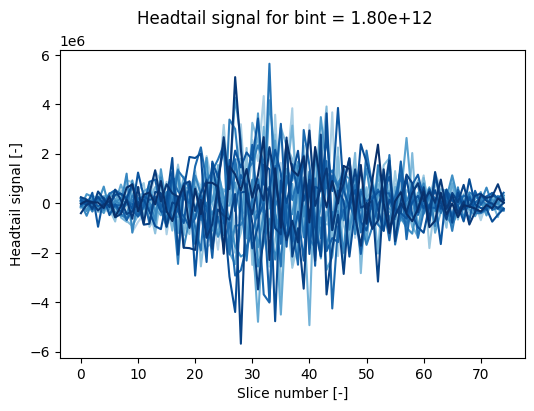

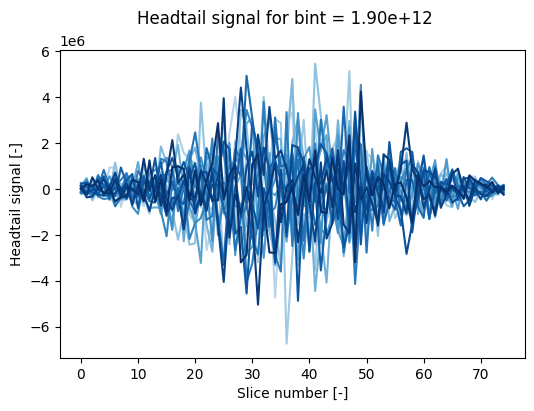

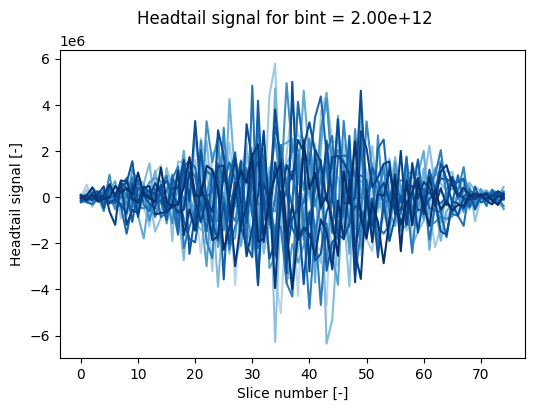

In [39]:
for bint in bunch_intensity_scan:

    # Open the file with the slice data
    with h5py.File(f'./bunchmonitor_data_hllhc_n{num_slices}/bunchmonitor_with_bellows_bint_{bint:.2e}_slices.h5', 'r') as h5file:
        mean_x = h5file['0']['mean_x'][:]
        num_particles = h5file['0']['num_particles'][:]

    turn_to_start_plot = 8000
    num_turn_to_plot = 20

    turn_range_to_plot = np.arange(turn_to_start_plot, turn_to_start_plot + num_turn_to_plot, 1)

    color_range = np.linspace(0.3, 1, num_turn_to_plot)

    fig, ax = plt.subplots(figsize=(6, 4))

    for ii_turn in turn_range_to_plot:

        ax.plot((mean_x * num_particles)[ii_turn, :], color=plt.cm.Blues(color_range[ii_turn-turn_to_start_plot]))

    ax.set_xlabel('Slice number [-]')
    ax.set_ylabel('Headtail signal [-]')

    fig.suptitle(f'Headtail signal for bint = {bint:.2e}')
